# Phân Loại Cảm Xúc Văn Bản Tài Chính Sử Dụng PhoBERT

- **Tổng quan**: Notebook này trình bày quy trình xây dựng mô hình phân loại cảm xúc trên các văn bản tài chính tiếng Việt.

- **Lưu ý**: Các bước thu thập và tiền xử lý dữ liệu sẽ được tiến hành tại local environment (Notebook này không trình bày).

- **Dữ liệu**:
  * Dữ liệu được sử dụng có nhãn được gán dựa vào 3 phương pháp sau:
    1. Biến động giá trị tuyệt đối (Absolute value fluctuation): *updating content*
    2. Lợi nhuận bất thường (Abnormal Return) và hệ số Alpha: *updating content*
    3. Giám sát yếu và Snorkel: *updating content*
  * Các lớp nhãn của bộ dữ liệu:
    1. Tích cực (0)
    2. Tiêu cực (1)
    3. Trung tính (2)
  * Định dạng dữ liệu:
    ```
     # | Column            | Dtype          | Meaning
    ---| ----------------- | -------------- | ---------------------------------------------       
     0 | symbol            | object         | Mã cổ phiếu được nhắc đến
     1 | publish_date      | datetime64[ns] | Ngày đăng tải bài viết
     2 | context_segmented | object         | Nội dung đã được tiền xử lý và tách từ
     3 | price_before      | float64        | Giá cổ phiếu trước khi bài viết đăng tải
     4 | price_after       | float64        | Giá cổ phiếu sau khi bài viết đăng tải
     5 | index_before      | float64        | Chỉ số thị trường trước khi bài viết đăng tải
     6 | index_after       | float64        | Chỉ số thị trường sau khi bài viết đăng tải
     7 | status            | object         | Trạng thái đầy đủ dữ liệu
     8 | label_vol         | int64          | Nhãn dựa vào biến động giá trị tuyệt đối
     9 | label_alpha       | int64          | Nhãn dựa vào lợi nhuận bất thường
    ```

- **Các bước tiến hành**:
  1. Cài đặt các thư viện và hằng số quan trọng
  2. Xử lý dữ liệu sẵn sàng huấn luyện mô hình
  3. Huấn luyện mô hình
  4. Đánh giá mô hình
  5. Sử dụng


# 1. Cài đặt các thư viện, hằng số quan trọng và hàm phụ trợ

## 1.1. Thư viện

In [1]:
## Lưu ý cài đặt numpy đúng phiên bản này, sau đó khởi động lại Session
!pip install numpy==1.26.4

In [2]:
!pip install wandb

In [3]:
!pip install transformers

In [4]:
!pip install datasets

In [5]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [6]:
!pip install scikit-learn

In [7]:
import os
import pandas as pd
import torch
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from google.colab import drive
from torch import nn
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
  AutoTokenizer,
  AutoModelForSequenceClassification,
  TrainingArguments,
  Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [8]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## 1.2. Hàm phụ trợ

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG)

logging.debug('Đây là thông báo debug')
logging.info('Đây là thông báo info')
logging.warning('Đây là thông báo warning')
logging.error('Đây là thông báo error')
logging.critical('Đây là thông báo critical')

ERROR:root:Đây là thông báo error
CRITICAL:root:Đây là thông báo critical


## 1.3. Hằng số

In [ ]:
POSITIVE = 0
NEGATIVE = 1
NEUTRAL = 2

version = "500_pages_batch_64"

# 2. Xử lý dữ liệu sẵn sàng huấn luyện mô hình

## 2.1. Kết nối drive

In [9]:
# Lưu ý thư viện này chỉ sử dụng được trên nền tảng GoogleColab
# Đối với môi trường local hoặc JupyterNotebook thì ...
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
project_path = "/content/drive/MyDrive/phobert_news_sentiment_analysis"
os.makedirs(project_path, exist_ok=True)

data_path = os.path.join(project_path, "data/labeled/dataset.csv")
df = pd.read_csv(data_path)

## 2.2. Kiểm tra dữ liệu thô

In [12]:
df.info()

pd.set_option('display.max_colwidth', None)
display(df.sample(5))
pd.reset_option('display.max_colwidth')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132225 entries, 0 to 132224
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   symbol             132225 non-null  object 
 1   publish_date       132225 non-null  object 
 2   context_segmented  132225 non-null  object 
 3   price_before       132225 non-null  float64
 4   price_after        132225 non-null  float64
 5   index_before       132225 non-null  float64
 6   index_after        132225 non-null  float64
 7   status             132225 non-null  object 
 8   label_vol          132225 non-null  int64  
 9   label_alpha        132225 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 10.1+ MB


,symbol,publish_date,context_segmented,price_before,price_after,index_before,index_after,status,label_vol,label_alpha
95037,LPB,2020-03-13,"Nhóm ngân_hàng có diễn_biến tích_cực hơn so với mặt_bằng chung thị_trường với nhiều mã tăng như CTG , MBB , STB , LPB , HDB , TCB .",2.85,2.73,719.21,698.18,ok,1,1
36324,VNM,2024-05-20,"Không hiếm cổ_phiếu tăng nóng nhờ "" sóng thoái vốn "" , tiêu_biểu nhất là VNM của Vinamilk và SAB của Sabeco .",62.05,61.31,1310.15,1308.62,ok,1,1
105645,HPG,2019-06-23,BVH trong tuần vẫn được khối ngoại mua ròng trên 72 tỷ đồng . HPG dù nằm trong diện giảm tỷ_trọng mạnh của FTSE nhưng tính chung cả tuần cổ_phiếu này vẫn được mua ròng hơn 55 tỷ đồng .,8.17,8.05,866.53,868.94,ok,1,1
41119,SSB,2023-12-27,"Dự_kiến giao_dịch thành_công , bà Nga sẽ nâng sở_hữu tại SSB lên hơn 97,22 triệu cổ_phiếu , tỷ_lệ 3,896% .",19.98,20.82,1115.52,1128.51,ok,0,0
5076,BID,2023-08-21,"Có 18 cổ_phiếu kết tăng_giá trong nhóm . Trong đó tăng mạnh nhất_là CTG ( +4,2% ) , BID ( +3,2% ) , TPB ( +2,2% ) , BCM ( +2,1% ) , SSI ( +1,9% ) .",32.41,33.59,1190.10,1193.51,ok,0,0


## 2.3. Chia bộ dữ liệu gốc cho nhiệm vụ Huấn luyện - Kiểm thử - Tinh chỉnh

In [34]:
from datasets import DatasetDict

dataset = Dataset.from_pandas(df.reset_index(drop=True))

# training : testing : validation = 7 : 2 : 1
test_and_train_val_dataset = dataset.train_test_split(test_size=0.5, seed=42)
test_dataset = test_and_train_val_dataset['test']
train_val = test_and_train_val_dataset['train']

traing_and_val_dataset = train_val.train_test_split(test_size=0.125, seed=42)
val_dataset = traing_and_val_dataset['test']
train_dataset = traing_and_val_dataset['train']

print(f"Total samples \t| {len(dataset)}")
print(f"Testing set \t| {len(test_dataset)} ({len(test_dataset)/len(dataset)*100:.1f}%)")
print(f"Traing set \t| {len(train_dataset)} ({len(train_dataset)/len(dataset)*100:.1f}%")
print(f"Validation set \t| {len(val_dataset)} ({len(val_dataset)/len(dataset)*100:.1f}%)")

dataset_splits = DatasetDict({
  'train': train_dataset,
  'validation': val_dataset,
  'test': test_dataset
})

Total samples 	| 132225
Testing set 	| 66113 (50.0%)
Traing set 	| 57848 (43.7%
Validation set 	| 8264 (6.2%)


In [15]:

for split_name, dataset_split in dataset_splits.items():
  print(f"--- Sample from {split_name.upper()} split ---")
  for i in range(min(1, len(dataset_split))):
    sample = dataset_split[i]
    print(f"Sample {i+1}:")
    print(f"  Symbol: {sample['symbol']}")
    print(f"  Publish Date: {sample['publish_date']}")
    print(f"  Context Segmented: {sample['context_segmented']}")
    print(f"  Price Before: {sample['price_before']}")
    print(f"  Price After: {sample['price_after']}")
    print(f"  Index Before: {sample['index_before']}")
    print(f"  Index After: {sample['index_after']}")
    print(f"  Status: {sample['status']}")
    print(f"  Label Vol: {sample['label_vol']}")
    print(f"  Label Alpha: {sample['label_alpha']}")
    print("-" * 20)
  print("\n")

--- Sample from TRAIN split ---
Sample 1:
  Symbol: SHB
  Publish Date: 2021-06-08
  Context Segmented: SHB - Ngân_hàng TMCP Sài_Gòn – Hà_Nội - Ông Đỗ_Quang_Vinh , con ông Đỗ_Quang_Hiển – Chủ_tịch HĐQT đăng_ký mua 500.000 cổ_phiếu SHB từ ngày 10/6 đến 08/7 theo phương_thức thoả_thuận và khớp lệnh . Hiện_tại , ông Vinh chưa nắm giữ bất_kỳ cổ_phiếu SHB nào .
  Price Before: 14.87
  Price After: 15.51
  Index Before: 1484.1
  Index After: 1457.76
  Status: ok
  Label Vol: 0
  Label Alpha: 0
--------------------


--- Sample from VALIDATION split ---
Sample 1:
  Symbol: MWG
  Publish Date: 2022-04-14
  Context Segmented: Theo đó , MWG sẽ chuyển_nhượng toàn_bộ số cổ_phần đang sở_hữu trong BHX cho công_ty mới thành_lập nói trên , giá_trị chuyển_nhượng là 12.795 tỷ đồng .
  Price Before: 76.25
  Price After: 78.2
  Index Before: 1525.39
  Index After: 1493.74
  Status: ok
  Label Vol: 0
  Label Alpha: 0
--------------------


--- Sample from TEST split ---
Sample 1:
  Symbol: STB
  Publish Da

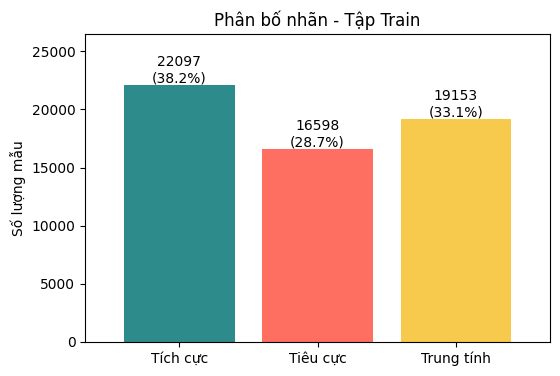

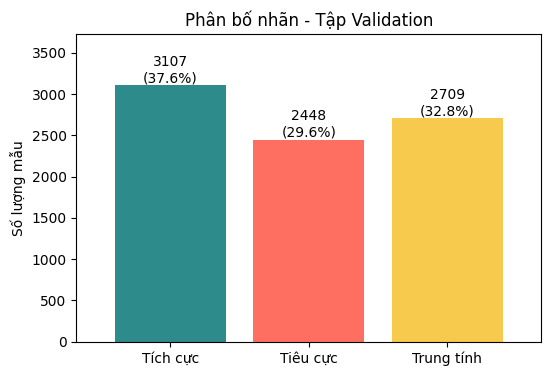

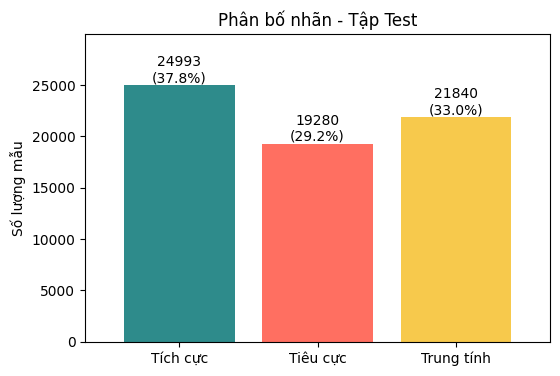

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_label_distribution(dataset_splits, label_col="label_alpha", title_prefix="Phân bố nhãn"):
  label_names = {0: "Tích cực", 1: "Tiêu cực", 2: "Trung tính"}
  colors = ['#2E8B8B', '#FF6F61', '#F7C94C']

  for split_name, dataset_split in dataset_splits.items():
    labels = [sample[label_col] for sample in dataset_split]
    labels_tensor = torch.tensor(labels)
    unique_labels, counts = torch.unique(labels_tensor, return_counts=True)

    label_count_dict = {int(label): int(count) for label, count in zip(unique_labels, counts)}
    total = sum(label_count_dict.values())


    sorted_labels = sorted(label_count_dict.keys())
    sorted_counts = [label_count_dict.get(label, 0) for label in sorted_labels]
    sorted_names = [label_names[label] for label in sorted_labels]
    sorted_colors = [colors[label] for label in sorted_labels]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(sorted_names, sorted_counts, color=sorted_colors)
    plt.ylabel("Số lượng mẫu")
    plt.title(f"{title_prefix} - Tập {split_name.capitalize()}")
    plt.xticks(sorted_names)

    for bar in bars:
      height = bar.get_height()
      percentage = (height / total) * 100 if total > 0 else 0
      plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}\n({percentage:.1f}%)',
                ha='center', va='bottom')

    plt.margins(x=0.1, y=0.2)
    plt.show()

plot_label_distribution(dataset_splits, label_col="label_vol")

Filter:   0%|          | 0/55751 [00:00<?, ? examples/s]

Lớp mục tiêu: 2, số lượng hiện tại: 19153
Thực hiện undersampling lớp 2 xuống còn 16000 mẫu.


Filter:   0%|          | 0/55751 [00:00<?, ? examples/s]

Filter:   0%|          | 0/55751 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)



Undersampling hoàn tất!
Kích thước tập train mới: 52598

--- Phân bố nhãn sau khi undersampling ---


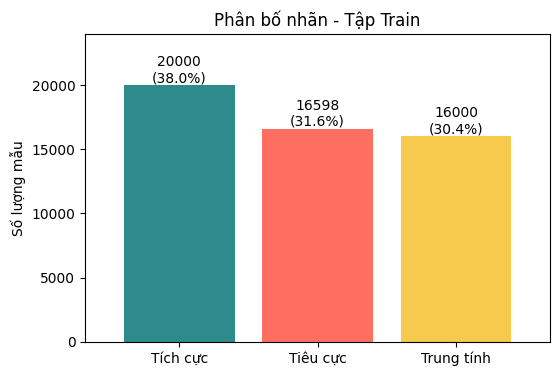

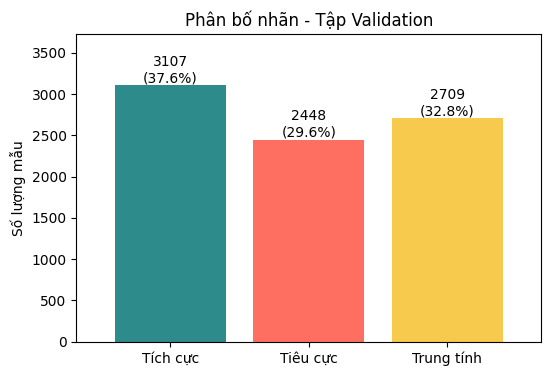

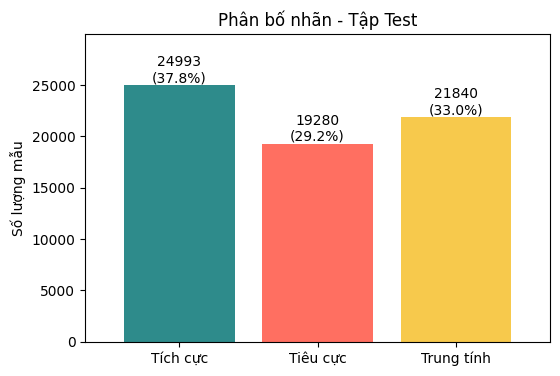

In [56]:
import numpy as np
from datasets import concatenate_datasets

target_class_label = 2
target_size = 16000
target_split_name = 'train'
label_column = 'label_vol'


train_dataset = dataset_splits[target_split_name]
try:
    current_size = len(train_dataset.filter(lambda x: x[label_column] == target_class_label))
    print(f"Lớp mục tiêu: {target_class_label}, số lượng hiện tại: {current_size}")

    if target_size < current_size:
        print(f"Thực hiện undersampling lớp {target_class_label} xuống còn {target_size} mẫu.")

        target_class_dataset = train_dataset.filter(lambda x: x[label_column] == target_class_label)
        other_classes_dataset = train_dataset.filter(lambda x: x[label_column] != target_class_label)

        undersampled_target_dataset = target_class_dataset.shuffle(seed=42).select(range(target_size))

        new_train_dataset = concatenate_datasets([other_classes_dataset, undersampled_target_dataset])
        new_train_dataset = new_train_dataset.shuffle(seed=42)

        dataset_splits[target_split_name] = new_train_dataset

        print("\nUndersampling hoàn tất!")
        print(f"Kích thước tập train mới: {len(dataset_splits[target_split_name])}")

        print("\n--- Phân bố nhãn sau khi undersampling ---")
        plot_label_distribution(dataset_splits, label_col=label_column)

    else:
        print(f"\nLỖI: Kích thước mục tiêu ({target_size}) phải nhỏ hơn số lượng hiện tại ({current_size}).")
        print("Undersampling không được thực hiện.")

except Exception as e:
    print(f"Đã xảy ra lỗi: {e}. Vui lòng kiểm tra lại tên cột nhãn và giá trị của các nhãn.")

# 3. Huấn luyện mô hình

## 3.1. Kết nối với Wandb để lưu hiệu suất mô hình

In [19]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: quanghuy71847 (quanghuy71847-ton-duc-thang-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 3.2. Cài đặt phần cứng

In [20]:
if torch.cuda.is_available():
  device = torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('Use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

There are 1 GPU(s) available.
Use the GPU: Tesla T4


## 3.3. Tải mô hình

In [21]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
  "vinai/phobert-base",
  num_labels=3
)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## 3.4. Tokenization

In [22]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=True)
tokenizer.add_special_tokens({'pad_token': '<pad>'})

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

0

In [23]:
model.resize_token_embeddings(len(tokenizer))

Embedding(64001, 768, padding_idx=1)

In [24]:
max_len = 256

def preprocess_function(examples):
  return tokenizer(
    examples["context_segmented"],
    truncation=True,
    padding="max_length",
    max_length=max_len,
    return_attention_mask=True,
    return_token_type_ids=True
  )


In [57]:
tokenized_splits = dataset_splits.map(preprocess_function, batched=True)

Map:   0%|          | 0/52598 [00:00<?, ? examples/s]

Map:   0%|          | 0/8264 [00:00<?, ? examples/s]

Map:   0%|          | 0/66113 [00:00<?, ? examples/s]

In [38]:
print(tokenized_splits)

DatasetDict({
    train: Dataset({
        features: ['symbol', 'publish_date', 'context_segmented', 'price_before', 'price_after', 'index_before', 'index_after', 'status', 'label_vol', 'label_alpha', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 55751
    })
    validation: Dataset({
        features: ['symbol', 'publish_date', 'context_segmented', 'price_before', 'price_after', 'index_before', 'index_after', 'status', 'label_vol', 'label_alpha', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8264
    })
    test: Dataset({
        features: ['symbol', 'publish_date', 'context_segmented', 'price_before', 'price_after', 'index_before', 'index_after', 'status', 'label_vol', 'label_alpha', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 66113
    })
})


In [58]:
tokenized_splits = tokenized_splits.rename_column("label_vol", "labels")
tokenized_splits = tokenized_splits.remove_columns(
  ["context_segmented", "symbol", "publish_date", "price_before", "price_after", "index_before", "index_after", "status"]
)

tokenized_splits.set_format(
  type="torch",
  columns=["input_ids", "attention_mask", "token_type_ids", "labels"]
)

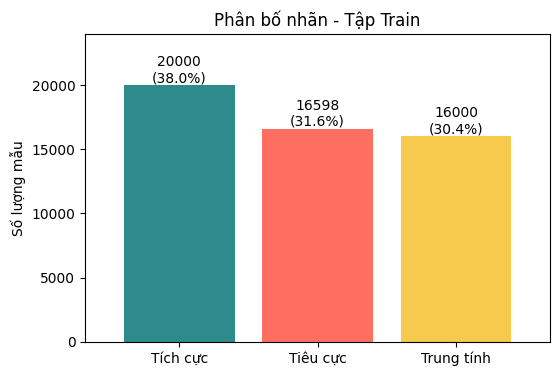

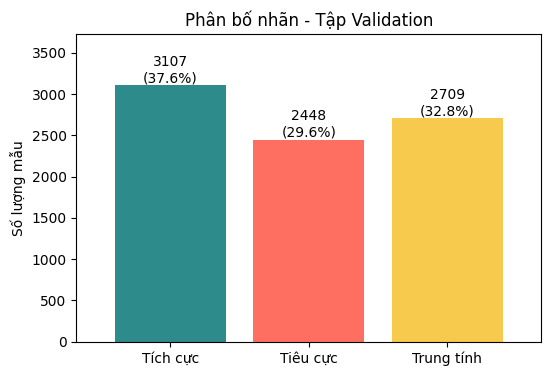

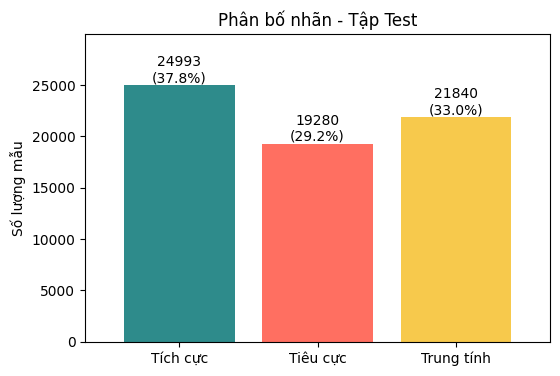

In [59]:
plot_label_distribution(tokenized_splits, label_col="labels")

## 3.5. Tính toán các chỉ số

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names=["positive", "negative", "neutral"]):
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

In [42]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


def compute_metrics(eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=-1)

  acc = accuracy_score(labels, preds)

  # Weighted average
  precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
    labels, preds, average='weighted'
  )

  # Macro average
  f1_macro = precision_recall_fscore_support(
    labels, preds, average='macro'
  )[2]

  # Per-class F1
  precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(
    labels, preds, average=None, labels=[0, 1, 2]
  )

  cm = confusion_matrix(labels, preds, labels=[0, 1, 2])
  plot_confusion_matrix(cm)

  return {
    "accuracy": acc,
    "precision_weighted": precision_w,
    "recall_weighted": recall_w,
    "f1_weighted": f1_w,
    "f1_macro": f1_macro,
    "f1_positive": f1_class[0],
    "f1_negative": f1_class[1],
    "f1_neutral": f1_class[2]
  }

## 3.6. Khởi tạo TrainingArguments

In [60]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
  output_dir=project_path + "/phobert-finetuned",
  logging_dir=project_path + "/logs",
  eval_strategy="steps",
  eval_steps=500,
  save_steps=1000,
  logging_steps=100,
  per_device_train_batch_size=64,
  per_device_eval_batch_size=64,
  num_train_epochs=3,
  learning_rate=3e-5,
  weight_decay=0.01,
  load_best_model_at_end=True,
  metric_for_best_model="accuracy",
  fp16=torch.cuda.is_available(),
  save_total_limit=2,
  seed=42,
  report_to="wandb",
  run_name="batch_64_3e-5_label_vol_train_0.5_pos_20k_neu_16k"
)

## 3.7. Khởi tạo Trainer

Step,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,F1 Macro,F1 Positive,F1 Negative,F1 Neutral
500,0.950700,1.018287,0.480276,0.478846,0.480276,0.478559,0.474398,0.551089,0.459600,0.412505
1000,0.877900,1.051149,0.482212,0.478767,0.482212,0.474372,0.469158,0.569099,0.456477,0.381898
1500,0.877700,1.031878,0.483543,0.482267,0.483543,0.480966,0.476892,0.555205,0.467331,0.408140
2000,0.813800,1.087744,0.485842,0.482713,0.485842,0.483737,0.480525,0.552236,0.488186,0.401154


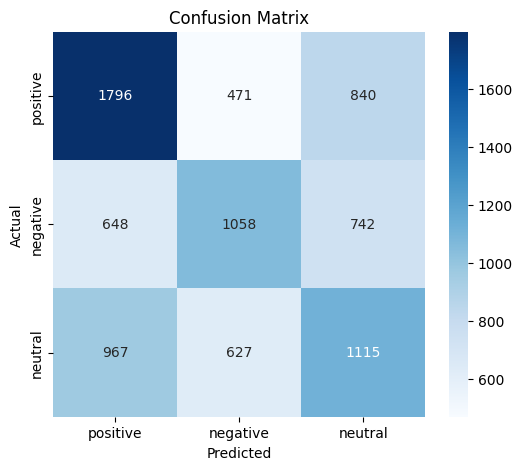

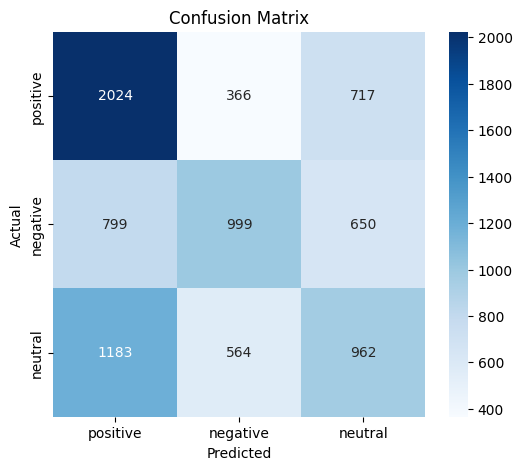

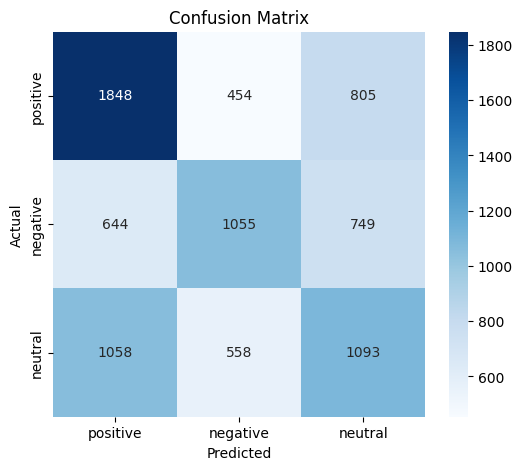

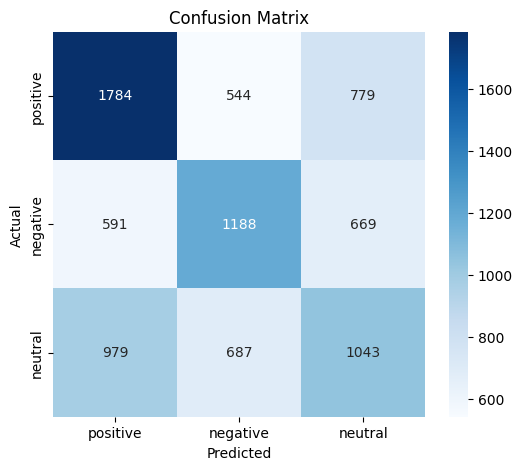

eval/accuracy,▁▃▅█
eval/f1_macro,▄▁▆█
eval/f1_negative,▂▁▃█
eval/f1_neutral,█▁▇▅
eval/f1_positive,▁█▃▁
eval/f1_weighted,▄▁▆█
eval/loss,▁▄▂█
eval/precision_weighted,▁▁▇█
eval/recall_weighted,▁▃▅█
eval/runtime,▁██▇
eval/samples_per_second,█▁▁▂


In [61]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=tokenized_splits["train"],
  eval_dataset=tokenized_splits["validation"],
  compute_metrics=compute_metrics,
  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
  data_collator=data_collator
)

trainer.train()

wandb.finish()

## 3.8. Lưu mô hình đã huấn luyện

In [62]:
trainer.save_model(project_path + "/phobert-sentiment-model_v2")
tokenizer.save_pretrained(project_path + "/phobert-sentiment-model_v2")

('/content/drive/MyDrive/phobert_news_sentiment_analysis/phobert-sentiment-model_v2/tokenizer_config.json',
 '/content/drive/MyDrive/phobert_news_sentiment_analysis/phobert-sentiment-model_v2/special_tokens_map.json',
 '/content/drive/MyDrive/phobert_news_sentiment_analysis/phobert-sentiment-model_v2/vocab.txt',
 '/content/drive/MyDrive/phobert_news_sentiment_analysis/phobert-sentiment-model_v2/bpe.codes',
 '/content/drive/MyDrive/phobert_news_sentiment_analysis/phobert-sentiment-model_v2/added_tokens.json')

# 4. Đánh giá mô hình

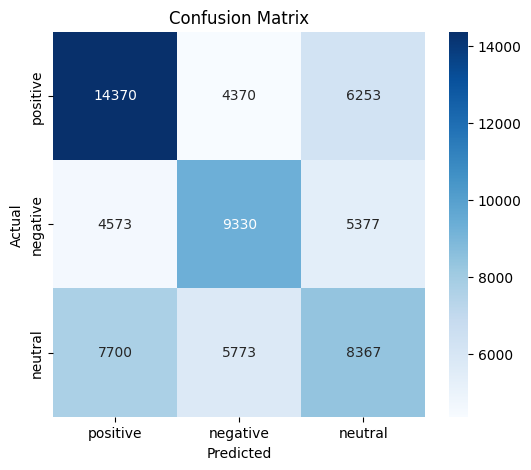

Kết quả đánh giá trên tập Test:
{'eval_loss': 1.0963106155395508, 'eval_accuracy': 0.48503320073207995, 'eval_precision_weighted': 0.48183761197220254, 'eval_recall_weighted': 0.48503320073207995, 'eval_f1_weighted': 0.48295994895440525, 'eval_f1_macro': 0.479360137888828, 'eval_f1_positive': 0.5565884266790612, 'eval_f1_negative': 0.4815111088173819, 'eval_f1_neutral': 0.39998087817004085, 'eval_runtime': 209.5212, 'eval_samples_per_second': 315.543, 'eval_steps_per_second': 4.935, 'epoch': 3.0}


eval/accuracy,▁
eval/f1_macro,▁
eval/f1_negative,▁
eval/f1_neutral,▁
eval/f1_positive,▁
eval/f1_weighted,▁
eval/loss,▁
eval/precision_weighted,▁
eval/recall_weighted,▁
eval/runtime,▁
eval/samples_per_second,▁


In [63]:
import wandb

wandb.init(project="phobert_news_sentiment_analysis",
           name="batch_64_3e-5_label_vol_train_0.5_pos_20k_neu_16k")

test_results = trainer.evaluate(tokenized_splits["test"])

print("Kết quả đánh giá trên tập Test:")
print(test_results)

wandb.finish()

# 5. Sử dụng

## 5.1. Tải mô hình và sử dụng để dự đoán

In [64]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model_path = project_path + "/phobert-sentiment-model"

loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)

loaded_model.eval()
if torch.cuda.is_available():
    loaded_model.to("cuda")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## 5.2. Hàm dự đoán cảm xúc

In [65]:
def predict_sentiment(text, tokenizer, model, device, max_len=256):
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    token_type_ids = encoding["token_type_ids"].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)

    predicted_label_id = torch.argmax(probabilities, dim=1).item()

    label_map = {0: "pos", 1: "nega", 2: "neu"}
    predicted_label = label_map[predicted_label_id]

    return predicted_label, probabilities[0].tolist()

## 5.3. Ví dụ sử dụng

In [66]:
sample_text = "Thị_trường gặp khủng_hoảng đại suy_thoái"
predicted_label, probabilities = predict_sentiment(sample_text, loaded_tokenizer, loaded_model, device)

print(f"Văn bản: '{sample_text}'")
print(f"Cảm xúc dự đoán: {predicted_label}")
print(f"Xác suất cho từng lớp (Tích cực, Tiêu cực, Trung tính): {probabilities}")

sample_text_2 = "Thị_trường đi lên mạnh_mẽ, nhóm ngành dầu_khí tăng cao đỉnh_điểm"
predicted_label_2, probabilities_2 = predict_sentiment(sample_text_2, loaded_tokenizer, loaded_model, device)

print(f"\nVăn bản: '{sample_text_2}'")
print(f"Cảm xúc dự đoán: {predicted_label_2}")
print(f"Xác suất cho từng lớp (Tích cực, Tiêu cực, Trung tính): {probabilities_2}")

sample_text_3 = "Thị_trường đi ngang, nhà đầu tư rút vốn"
predicted_label_3, probabilities_3 = predict_sentiment(sample_text_3, loaded_tokenizer, loaded_model, device)

print(f"\nVăn bản: '{sample_text_3}'")
print(f"Cảm xúc dự đoán: {predicted_label_3}")
print(f"Xác suất cho từng lớp (Tích cực, Tiêu cực, Trung tính): {probabilities_3}")


# Test bằng data huấn luyện
sample_text_4 = "Theo sau là nhóm cổ_phiếu dầu_khí và dịch_vụ tiêu_dùng . Cổ_phiếu thực_phẩm tăng mạnh nhất trong phiên hôm_nay , với MSN tăng 3,5% , HAG tăng 1,6% , VNM tăng 3,6% , SAB tăng 0,6% , VHC tăng 3,2% . Theo sau là nhóm cổ_phiếu dầu_khí và dịch_vụ tiêu_dùng."
predicted_label_4, probabilities_4 = predict_sentiment(sample_text_4, loaded_tokenizer, loaded_model, device)

print(f"\nVăn bản: '{sample_text_4}'")
print(f"Cảm xúc dự đoán: {predicted_label_4}")
print(f"Xác suất cho từng lớp (Tích cực, Tiêu cực, Trung tính): {probabilities_4}")

sample_text_5 = "Thị_trường bình_thường, không thay_đổi"
predicted_label_5, probabilities_5 = predict_sentiment(sample_text_5, loaded_tokenizer, loaded_model, device)

print(f"\nVăn bản: '{sample_text_5}'")
print(f"Cảm xúc dự đoán: {predicted_label_5}")
print(f"Xác suất cho từng lớp (Tích cực, Tiêu cực, Trung tính): {probabilities_5}")

Văn bản: 'Thị_trường gặp khủng_hoảng đại suy_thoái'
Cảm xúc dự đoán: nega
Xác suất cho từng lớp (Tích cực, Tiêu cực, Trung tính): [0.30327993631362915, 0.5268771648406982, 0.1698428839445114]

Văn bản: 'Thị_trường đi lên mạnh_mẽ, nhóm ngành dầu_khí tăng cao đỉnh_điểm'
Cảm xúc dự đoán: pos
Xác suất cho từng lớp (Tích cực, Tiêu cực, Trung tính): [0.7656041383743286, 0.101288802921772, 0.13310708105564117]

Văn bản: 'Thị_trường đi ngang, nhà đầu tư rút vốn'
Cảm xúc dự đoán: nega
Xác suất cho từng lớp (Tích cực, Tiêu cực, Trung tính): [0.33041393756866455, 0.37771904468536377, 0.29186704754829407]

Văn bản: 'Theo sau là nhóm cổ_phiếu dầu_khí và dịch_vụ tiêu_dùng . Cổ_phiếu thực_phẩm tăng mạnh nhất trong phiên hôm_nay , với MSN tăng 3,5% , HAG tăng 1,6% , VNM tăng 3,6% , SAB tăng 0,6% , VHC tăng 3,2% . Theo sau là nhóm cổ_phiếu dầu_khí và dịch_vụ tiêu_dùng.'
Cảm xúc dự đoán: pos
Xác suất cho từng lớp (Tích cực, Tiêu cực, Trung tính): [0.7531614899635315, 0.02470616064965725, 0.2221323102712

# Thông tin tác giả

- Tên: Quang Huy (Victor) Nguyen
- Email: quanghuy71847@gmail.com / 523h0140@student.tdtu.edu.vn
- Tổ chức: Trường Đại Học Tôn Đức Thắng - Khoa Công Nghệ Thông Tin - Chuyên ngành Khoa Học Máy Tính
- Bản quyền: © 2025 Quang Huy (Victor) Nguyen. Tất cả quyền được bảo lưu.